## Week 6 - Session 2: DCGAN with MNIST

* Development environment: 
        cuda 8.0
        Python 3.5.3
        tensorflow-gpu 1.2.1
        numpy 1.13.1
        matplotlib 2.0.2
        imageio 2.2.0

* if you have a later version of tensorflow, there could be deprecation warnings.

"""
Source: https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN
"""

In [1]:
import os, time, itertools, imageio, pickle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import input_data
tf.compat.v1.disable_eager_execution()

### Generator & Discriminator

In [2]:
def lrelu(x, th=0.2):
    # the leaku ReLU, helps avoid the dying ReLU neuron where the inputs to the activation are also <0 and thus
    # the neuron only ever outputs zero. Also, the ReLU can suffer from the exploding gradient issue, just to note
    return tf.maximum(th * x, x)

# G(z)
def generator(x, isTrain=True, reuse=False):
    with tf.compat.v1.variable_scope('generator', reuse=reuse):
        # to help understand conv2d_tranpose, here is a nice link:
        # https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers
        
        # "one way to get a really basic level intuition behind convolution is that you are sliding K filters, 
        # which you can think of as K stencils, over the input image and produce K activations - 
        # each one representing a degree of match with a particular stencil. 
        # The inverse operation of that would be to take K activations and expand them into a preimage of 
        # the convolution operation. The intuitive explanation of the inverse operation is therefore, roughly, 
        # image reconstruction given the stencils (filters) and activations (the degree of the match for each stencil) 
        # and therefore at the basic intuitive level we want to blow up each activation by the stencil's mask 
        # and add them up"
        
        # 1st hidden layer
        conv1 = tf.compat.v1.layers.conv2d_transpose(x, 1024, [4, 4], strides=(1, 1), padding='valid')
        lrelu1 = lrelu(tf.compat.v1.layers.batch_normalization(conv1, training=isTrain), 0.2)

        # 2nd hidden layer
        conv2 = tf.compat.v1.layers.conv2d_transpose(lrelu1, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.compat.v1.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.compat.v1.layers.conv2d_transpose(lrelu2, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.compat.v1.layers.batch_normalization(conv3, training=isTrain), 0.2)

        # 4th hidden layer
        conv4 = tf.compat.v1.layers.conv2d_transpose(lrelu3, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.compat.v1.layers.batch_normalization(conv4, training=isTrain), 0.2)

        # output layer
        conv5 = tf.compat.v1.layers.conv2d_transpose(lrelu4, 1, [4, 4], strides=(2, 2), padding='same')
        o = tf.nn.tanh(conv5)

        return o

# D(x)
def discriminator(x, isTrain=True, reuse=False):
    with tf.compat.v1.variable_scope('discriminator', reuse=reuse):
        # 1st hidden layer
        conv1 = tf.compat.v1.layers.conv2d(x, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu1 = lrelu(conv1, 0.2)

        # 2nd hidden layer
        conv2 = tf.compat.v1.layers.conv2d(lrelu1, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.compat.v1.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.compat.v1.layers.conv2d(lrelu2, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.compat.v1.layers.batch_normalization(conv3, training=isTrain), 0.2)

        # 4th hidden layer
        conv4 = tf.compat.v1.layers.conv2d(lrelu3, 1024, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.compat.v1.layers.batch_normalization(conv4, training=isTrain), 0.2)

        # output layer
        conv5 = tf.compat.v1.layers.conv2d(lrelu4, 1, [4, 4], strides=(1, 1), padding='valid')
        o = tf.nn.sigmoid(conv5)

        return o, conv5

### Functions for Training/ Results

In [3]:
fixed_z_ = np.random.normal(0, 1, (25, 1, 1, 100))
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    test_images = sess.run(G_z, {z: fixed_z_, isTrain: False})

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (64, 64)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

### Start to train GAN
 - Define the networks, loss function, and optimizer

In [ ]:
# training parameters
batch_size = 100
train_epoch = 20   # Reduce the training epoch to save time. 
lr = 0.0002 

# load MNIST
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])

# variables : input
x = tf.compat.v1.placeholder(tf.float32, shape=(None, 64, 64, 1))
z = tf.compat.v1.placeholder(tf.float32, shape=(None, 1, 1, 100))
isTrain = tf.compat.v1.placeholder(dtype=tf.bool)

# networks : generator
G_z = generator(z, isTrain)

# networks : discriminator
D_real, D_real_logits = discriminator(x, isTrain)
D_fake, D_fake_logits = discriminator(G_z, isTrain, reuse=True)

# loss for each network
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1, 1, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1, 1, 1])))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1, 1, 1])))

# trainable variables for each network
T_vars = tf.compat.v1.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

# optimizer for each network
with tf.control_dependencies(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)):
    D_optim = tf.compat.v1.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optim = tf.compat.v1.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)


### GPU Setting

In [ ]:
# open session and initialize all variables

if True: # If you have multiple GPUs, you can set up how to use GPUs. Otherwise, set False
    os.environ['TF_CPP_MIN_LOG_LEVEL']='2'           # Ignore detailed log massages for GPU
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # the IDs match nvidia-smi
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'         # GPU-ID "0" or "0, 1" for multiple
    config = tf.compat.v1.ConfigProto()   
    config.gpu_options.visible_device_list= '0'      # only see the gpu 1
    config.gpu_options.per_process_gpu_memory_fraction = 0.5 
    #config.gpu_options.allow_growth = True 
    
    sess = tf.compat.v1.InteractiveSession(config=config)
else:  # If you do not have a GPU
    sess = tf.compat.v1.InteractiveSession()

### Training
- Review the given output for discussion. The given output was generated with 20 epochs.
- Please do not wait to finish training DCGAN during the workshop. It took ~52 min to train 20 epochs with a GPU (Titan XP). 
- When trainig it, you may reduce the training epoch.

training start!
[1/20] - ptime: 150.50 loss_d: 0.830, loss_g: 4.358


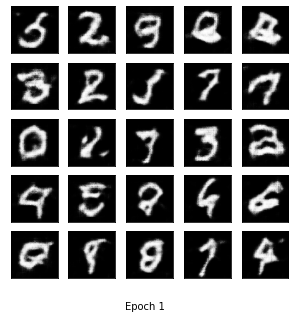

[2/20] - ptime: 150.52 loss_d: 0.656, loss_g: 3.039


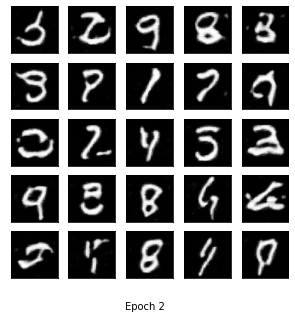

[3/20] - ptime: 150.94 loss_d: 0.380, loss_g: 4.339


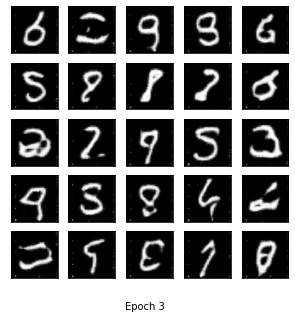

[4/20] - ptime: 151.50 loss_d: 0.488, loss_g: 4.233


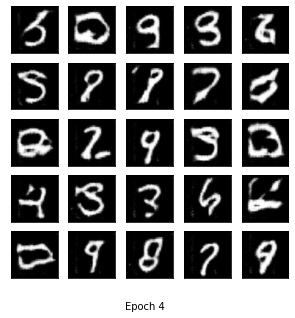

[5/20] - ptime: 151.66 loss_d: 0.299, loss_g: 4.761


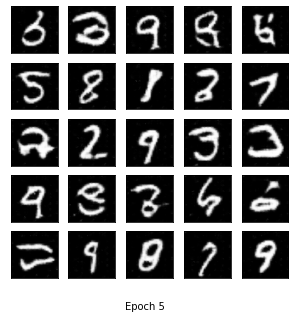

[6/20] - ptime: 151.27 loss_d: 0.597, loss_g: 3.542


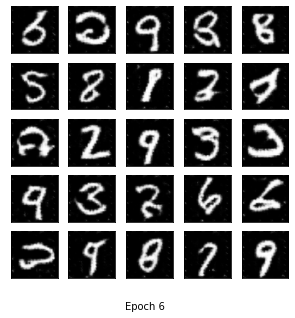

[7/20] - ptime: 151.50 loss_d: 0.275, loss_g: 4.985


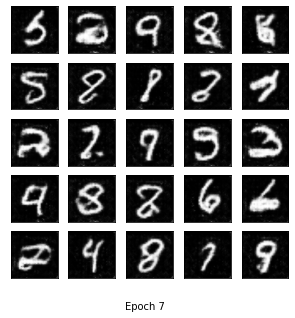

[8/20] - ptime: 151.75 loss_d: 0.651, loss_g: 3.962


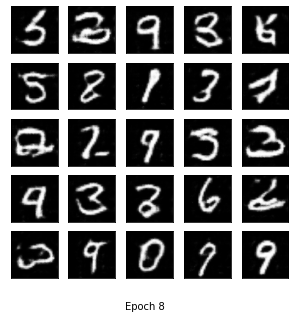

[9/20] - ptime: 151.67 loss_d: 0.281, loss_g: 4.902


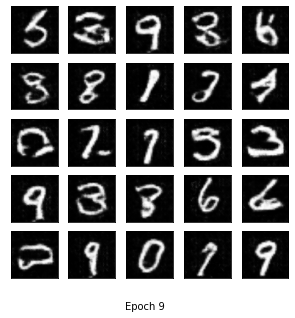

[10/20] - ptime: 152.38 loss_d: 0.271, loss_g: 5.386


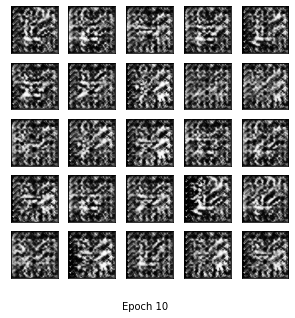

[11/20] - ptime: 160.88 loss_d: 0.363, loss_g: 7.265


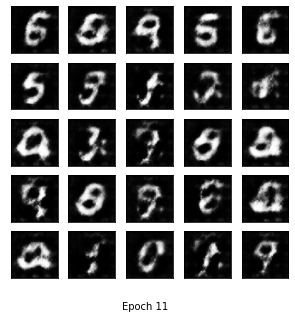

[12/20] - ptime: 151.75 loss_d: 0.441, loss_g: 4.428


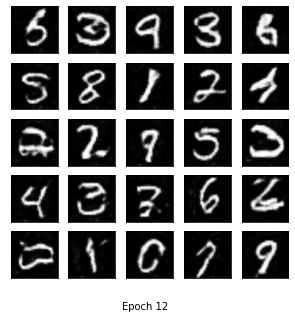

[13/20] - ptime: 151.33 loss_d: 0.372, loss_g: 4.739


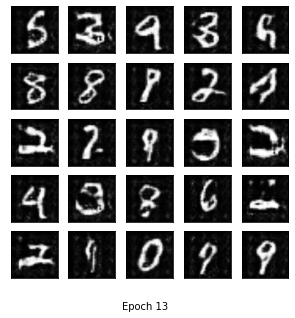

[14/20] - ptime: 151.20 loss_d: 0.352, loss_g: 4.299


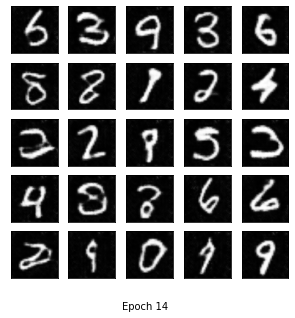

[15/20] - ptime: 151.47 loss_d: 0.209, loss_g: 5.528


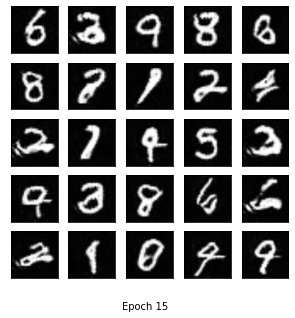

[16/20] - ptime: 151.84 loss_d: 0.289, loss_g: 4.879


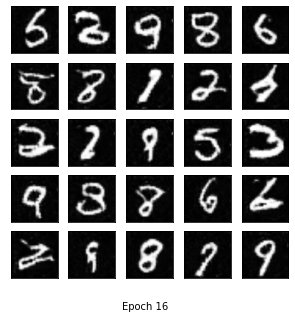

[17/20] - ptime: 152.00 loss_d: 0.282, loss_g: 5.099


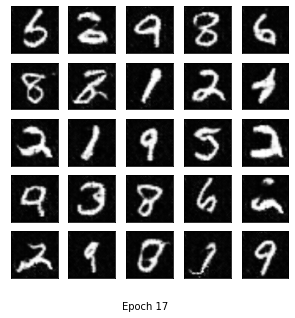

[18/20] - ptime: 152.13 loss_d: 0.460, loss_g: 4.784


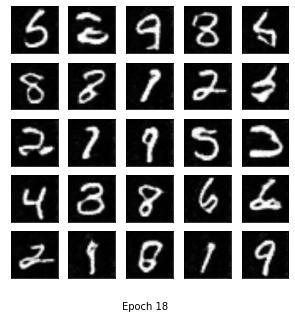

[19/20] - ptime: 152.07 loss_d: 0.372, loss_g: 4.086


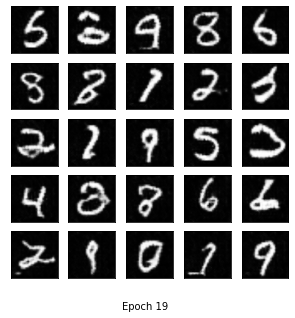

[20/20] - ptime: 151.79 loss_d: 0.069, loss_g: 6.978


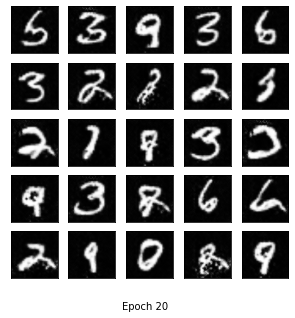

Avg per epoch ptime: 152.01, total 20 epochs ptime: 3070.29
Training finish!... save training results


In [13]:

tf.compat.v1.global_variables_initializer().run()

# MNIST resize and normalization
train_set = tf.compat.v1.image.resize_images(mnist.train.images, [64, 64]).eval()
train_set = (train_set - 0.5) / 0.5  # normalization; range: -1 ~ 1

# results save folder
root = 'MNIST_DCGAN_results/'
model = 'MNIST_DCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# training-loop
np.random.seed(int(time.time()))
print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()
    for iter in range(mnist.train.num_examples // batch_size):
        # update discriminator
        x_ = train_set[iter*batch_size:(iter+1)*batch_size]
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))

        loss_d_, _ = sess.run([D_loss, D_optim], {x: x_, z: z_, isTrain: True})
        D_losses.append(loss_d_)

        # update generator
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        loss_g_, _ = sess.run([G_loss, G_optim], {z: z_, x: x_, isTrain: True})
        G_losses.append(loss_g_)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch + 1), show=True, path=fixed_p)
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), train_epoch, total_ptime))
print("Training finish!... save training results")
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

sess.close()

### Questions
1. Compare the generated outputs from DCGAN with the ones from GAN.
2. Compare the loss of discriminator (loss_d) with the loss of generator (loss_g) during training. What kinds of trends do you observe? What does it mean?

        loss graph: ./MNIST_DCGAN_results/MNIST_DCGAN_train_hist.png 
        
3. Why does a DCGAN outperform a vanilla GAN?
4. In the given training output, what happend in epoch 10?
5. Can you distinguish the (fake) digit images generated by DCGAN from the real ones?

        Applications using GAN?
        Any risks or ethical issues regarding GANs?